In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')
df.shape

(20640, 10)

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df_sub = df[df['ocean_proximity'].isin(['<1H OCEAN','INLAND'])]
df_sub.shape

(15687, 10)

In [5]:
#1. There's one feature with missing values. What is it?
df_sub.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [6]:
#2. What's the median (50% percentile) for variable 'population'?

df_sub.population.median()

1195.0

In [7]:
# Prepare and split the dataset
#     Shuffle the dataset (the filtered one you created above), use seed 42.
#     Split your data in train/val/test sets, with 60%/20%/20% distribution.
#     Apply the log transformation to the median_house_value variable using the np.log1p() function.
np.random.seed(42)
n=len(df_sub)
n_val = int(0.2*n)
n_test = int(0.2*n)
n_train = n - (n_val+n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df_sub.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()



y_train_orig = df_train['median_house_value'].values
y_val_orig = df_val['median_house_value'].values
y_test_orig = df_test['median_house_value'].values

y_train = np.log1p(df_train['median_house_value'].values)
y_val = np.log1p(df_val['median_house_value'].values)
y_test = np.log1p(df_test['median_house_value'].values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']



In [8]:
#3.
#     We need to deal with missing values for the column from Q1.
#     We have two options: fill it with 0 or with the mean of this variable.
#     Try both options. For each, train a linear regression model without regularization using the code from the lessons.
#     For computing the mean, use the training only!
#     Use the validation dataset to evaluate the models and compare the RMSE of each option.
#     Round the RMSE scores to 2 decimal digits using round(score, 2)
#     Which option gives better RMSE?


In [9]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]



In [10]:
base = ['longitude', 'latitude', 'housing_median_age', 'total_rooms','total_bedrooms', 'population', 'households', 'median_income']

In [11]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

def prepare_X_med(df):
    df_num = df[base]
    df_num = df_num.fillna(df.total_bedrooms.mean())
    X = df_num.values
    return X

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [12]:
#without mean
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
rmse(y_train, y_pred)

0.3402719715829533

In [14]:
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
rmse(y_val, y_pred)

0.34084790341731247

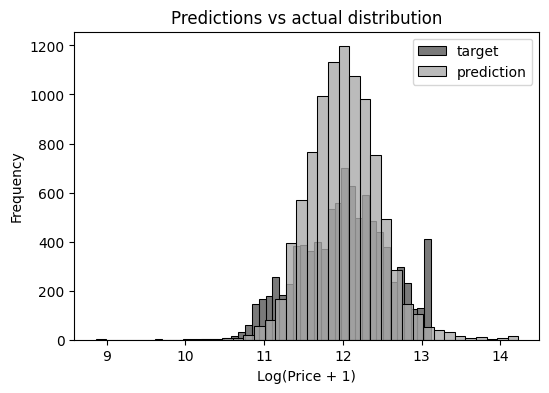

In [13]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

In [15]:
#with mean values
X_train = prepare_X_med(df_train)
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)
rmse(y_train, y_pred)

0.34003008222642594

In [16]:
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
rmse(y_val, y_pred)

0.34114423385442655

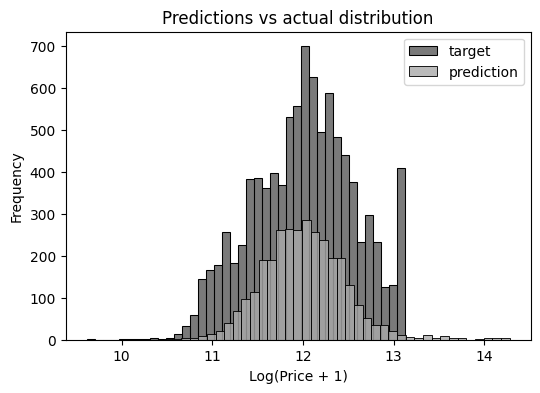

In [17]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

In [ ]:
# 4.
#     Now let's train a regularized linear regression.
#     For this question, fill the NAs with 0.
#     Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
#     Use RMSE to evaluate the model on the validation dataset.
#     Round the RMSE scores to 2 decimal digits.
#     Which r gives the best RMSE?

# If there are multiple options, select the smallest r.

In [18]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]



In [22]:
X_train = prepare_X(df_train)

for r in [0, 0.001, 0.01, 0.1, 1, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    print('%5s, %.2f, %.2f, %.2f' % (r, w_0, w[-4], w[-1]))



    0, -9.76, 0.00, 0.18
0.001, -9.74, 0.00, 0.18
 0.01, -9.56, 0.00, 0.18
  0.1, -8.06, 0.00, 0.18
    1, -3.13, 0.00, 0.19
   10, -0.44, 0.00, 0.19


In [23]:


X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0)

y_pred = w_0 + X_train.dot(w)
print('train', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('val', rmse(y_val, y_pred))



train 0.3402719715829533
val 0.34084790341731247


In [24]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

y_pred = w_0 + X_train.dot(w)
print('train', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('val', rmse(y_val, y_pred))

train 0.34027499089643504
val 0.34087793005015365


In [25]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, rmse(y_val, y_pred))


 1e-06 0.3408479061774172
0.0001 0.3408481800503766
 0.001 0.3408506921871732
  0.01 0.34087793005015365
   0.1 0.3412862041992782
     1 0.344895832764545
     5 0.34773980704776924
    10 0.34831498335189415
